# **Text Summarization System**

**Neural Network and Deep Learning (COMP 488)**

**Mini Project**

In [1]:
!pip install openpyxl  --quiet

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
import string
import tensorflow as tf
import re
import os
import time
from tensorflow import keras

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [4]:
ENCODER_LEN = 100
DECODER_LEN = 20
BATCH_SIZE = 64
BUFFER_SIZE = BATCH_SIZE * 8

In [5]:
news = pd.read_excel("/kaggle/input/cnn-dailymail/data.xlsx",engine = 'openpyxl')
news.head()

,Headline,Short
0,4 ex-bank officials booked for cheating bank o...,The CBI on Saturday booked four former officia...
1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme C...
2,"At least 3 killed, 30 injured in blast in Sylh...","At least three people were killed, including a..."
3,Why has Reliance been barred from trading in f...,Mukesh Ambani-led Reliance Industries (RIL) wa...
4,Was stopped from entering my own studio at Tim...,TV news anchor Arnab Goswami has said he was t...


In [6]:
article = news['Short']
summary = news['Headline']
article = article.apply(lambda x: '<SOS> ' + x + ' <EOS>')
summary = summary.apply(lambda x: '<SOS> ' + x + ' <EOS>')

In [7]:
def preprocess(text):
    text = re.sub(r"&.[1-9]+;"," ",text)
    return text

article = article.apply(lambda x: preprocess(x))
summary = summary.apply(lambda x: preprocess(x))

In [8]:
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
oov_token = '<unk>'
article_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token=oov_token)
summary_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)
article_tokenizer.fit_on_texts(article)
summary_tokenizer.fit_on_texts(summary)
inputs = article_tokenizer.texts_to_sequences(article)
targets = summary_tokenizer.texts_to_sequences(summary)

In [9]:
ENCODER_VOCAB = len(article_tokenizer.word_index) + 1
DECODER_VOCAB = len(summary_tokenizer.word_index) + 1
print(ENCODER_VOCAB, DECODER_VOCAB)

76362 29661


In [10]:
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=ENCODER_LEN, padding='post', truncating='post')
targets = tf.keras.preprocessing.sequence.pad_sequences(targets, maxlen=DECODER_LEN, padding='post', truncating='post')
inputs = tf.cast(inputs, dtype=tf.int64)
targets = tf.cast(targets, dtype=tf.int64)

In [11]:
dataset = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [12]:
def calculate_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

In [13]:
def generate_positional_encoding(position, d_model):
    angle_rads = calculate_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [14]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

In [15]:
def generate_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

In [16]:
def compute_scaled_dot_product(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights

In [17]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = compute_scaled_dot_product(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
            
        return output, attention_weights

In [18]:
def built_pointwise_feedforward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

In [19]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = built_pointwise_feedforward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [20]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = built_pointwise_feedforward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2

In [21]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = generate_positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)
    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
    
        return x
    
class Decoder(tf.keras.layers.Layer):
        
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = generate_positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        return x, attention_weights
    

In [22]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)

        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

In [23]:
num_layers = 3
d_model = 128
dff = 512
num_heads = 4
dropout_rate = 0.2
EPOCHS = 100

In [24]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return (tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2))

In [25]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

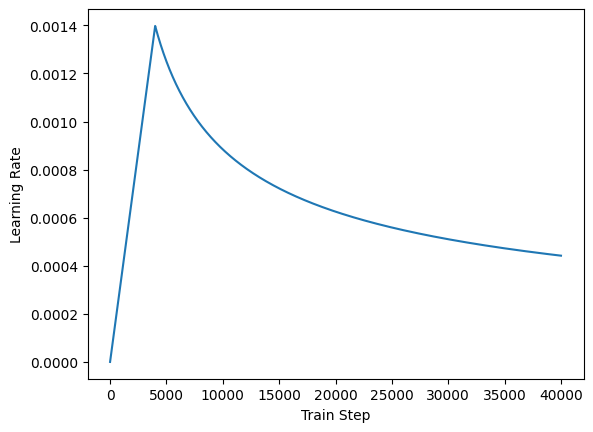

In [26]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [27]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))
    #accuracies = tf.cast(accuracies, dtype= tf.float32)

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [28]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [29]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=ENCODER_VOCAB,
    target_vocab_size=DECODER_VOCAB,
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [30]:
def generate_masks(inp, tar):
    enc_padding_mask = generate_padding_mask(inp)
    dec_padding_mask = generate_padding_mask(inp)

    look_ahead_mask = generate_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = generate_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

In [31]:
checkpoint_path = "checkpoints"

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [32]:
@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = generate_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inp, tar_inp, 
            True, 
            enc_padding_mask, 
            combined_mask, 
            dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

In [33]:
loss_values=[]
accuracy_values=[]

In [34]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
  
    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)
    
        if batch % 100 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
      
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
   
    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
    loss_values.append(train_loss.result())
    accuracy_values.append(train_accuracy.result())
    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 10.3189 Accuracy 0.0000


Epoch 1 Batch 100 Loss 10.2064 Accuracy 0.0551


Epoch 1 Batch 200 Loss 9.9871 Accuracy 0.0749


Epoch 1 Batch 300 Loss 9.6757 Accuracy 0.0821


Epoch 1 Batch 400 Loss 9.3310 Accuracy 0.0865


Epoch 1 Batch 500 Loss 9.0170 Accuracy 0.0902


Epoch 1 Batch 600 Loss 8.7712 Accuracy 0.0941


Epoch 1 Batch 700 Loss 8.5768 Accuracy 0.0997


Epoch 1 Batch 800 Loss 8.4191 Accuracy 0.1046


Epoch 1 Loss 8.3337 Accuracy 0.1074
Time taken for 1 epoch: 150.53101778030396 secs



Epoch 2 Batch 0 Loss 7.4775 Accuracy 0.1074


Epoch 2 Batch 100 Loss 7.3673 Accuracy 0.1088


Epoch 2 Batch 200 Loss 7.2892 Accuracy 0.1106


Epoch 2 Batch 300 Loss 7.2105 Accuracy 0.1127


Epoch 2 Batch 400 Loss 7.1611 Accuracy 0.1149


Epoch 2 Batch 500 Loss 7.1060 Accuracy 0.1177


Epoch 2 Batch 600 Loss 7.0501 Accuracy 0.1205


Epoch 2 Batch 700 Loss 6.9891 Accuracy 0.1237


Epoch 2 Batch 800 Loss 6.9236 Accuracy 0.1271


Epoch 2 Loss 6.8809 Accuracy 0.1291
Time taken for 1 epoch: 84.8046772480011 secs

Epoch 3 Batch 0 Loss 6.7815 Accuracy 0.1292


Epoch 3 Batch 100 Loss 6.6383 Accuracy 0.1302


Epoch 3 Batch 200 Loss 6.5448 Accuracy 0.1317


Epoch 3 Batch 300 Loss 6.4681 Accuracy 0.1334


Epoch 3 Batch 400 Loss 6.4199 Accuracy 0.1353


Epoch 3 Batch 500 Loss 6.3710 Accuracy 0.1376


Epoch 3 Batch 600 Loss 6.3236 Accuracy 0.1402


Epoch 3 Batch 700 Loss 6.2683 Accuracy 0.1430


Epoch 3 Batch 800 Loss 6.2105 Accuracy 0.1459


Epoch 3 Loss 6.1728 Accuracy 0.1478
Time taken for 1 epoch: 82.8121075630188 secs

Epoch 4 Batch 0 Loss 6.5927 Accuracy 0.1478


Epoch 4 Batch 100 Loss 6.0724 Accuracy 0.1489


Epoch 4 Batch 200 Loss 5.9866 Accuracy 0.1504


Epoch 4 Batch 300 Loss 5.9164 Accuracy 0.1521


Epoch 4 Batch 400 Loss 5.8754 Accuracy 0.1539


Epoch 4 Batch 500 Loss 5.8331 Accuracy 0.1560


Epoch 4 Batch 600 Loss 5.7911 Accuracy 0.1584


Epoch 4 Batch 700 Loss 5.7397 Accuracy 0.1611


Epoch 4 Batch 800 Loss 5.6844 Accuracy 0.1639


Epoch 4 Loss 5.6490 Accuracy 0.1656
Time taken for 1 epoch: 82.2544732093811 secs

Epoch 5 Batch 0 Loss 6.0355 Accuracy 0.1656


Epoch 5 Batch 100 Loss 5.6279 Accuracy 0.1669


Epoch 5 Batch 200 Loss 5.5359 Accuracy 0.1685


Epoch 5 Batch 300 Loss 5.4669 Accuracy 0.1704


Epoch 5 Batch 400 Loss 5.4349 Accuracy 0.1722


Epoch 5 Batch 500 Loss 5.3919 Accuracy 0.1743


Epoch 5 Batch 600 Loss 5.3495 Accuracy 0.1766


Epoch 5 Batch 700 Loss 5.3013 Accuracy 0.1791


Epoch 5 Batch 800 Loss 5.2468 Accuracy 0.1818


Saving checkpoint for epoch 5 at checkpoints/ckpt-1
Epoch 5 Loss 5.2123 Accuracy 0.1835
Time taken for 1 epoch: 83.21591639518738 secs

Epoch 6 Batch 0 Loss 5.8740 Accuracy 0.1835


Epoch 6 Batch 100 Loss 5.2347 Accuracy 0.1849


Epoch 6 Batch 200 Loss 5.1428 Accuracy 0.1866


Epoch 6 Batch 300 Loss 5.0678 Accuracy 0.1885


Epoch 6 Batch 400 Loss 5.0277 Accuracy 0.1904


Epoch 6 Batch 500 Loss 4.9767 Accuracy 0.1926


Epoch 6 Batch 600 Loss 4.9287 Accuracy 0.1949


Epoch 6 Batch 700 Loss 4.8773 Accuracy 0.1974


Epoch 6 Batch 800 Loss 4.8210 Accuracy 0.2002


Epoch 6 Loss 4.7890 Accuracy 0.2018
Time taken for 1 epoch: 81.99781060218811 secs

Epoch 7 Batch 0 Loss 5.4190 Accuracy 0.2018


Epoch 7 Batch 100 Loss 4.8571 Accuracy 0.2032


Epoch 7 Batch 200 Loss 4.7619 Accuracy 0.2049


Epoch 7 Batch 300 Loss 4.6885 Accuracy 0.2069


Epoch 7 Batch 400 Loss 4.6523 Accuracy 0.2087


Epoch 7 Batch 500 Loss 4.6002 Accuracy 0.2109


Epoch 7 Batch 600 Loss 4.5570 Accuracy 0.2131


Epoch 7 Batch 700 Loss 4.5075 Accuracy 0.2156


Epoch 7 Batch 800 Loss 4.4557 Accuracy 0.2182


Epoch 7 Loss 4.4264 Accuracy 0.2197
Time taken for 1 epoch: 82.14209938049316 secs

Epoch 8 Batch 0 Loss 5.0068 Accuracy 0.2197


Epoch 8 Batch 100 Loss 4.5559 Accuracy 0.2212


Epoch 8 Batch 200 Loss 4.4543 Accuracy 0.2229


Epoch 8 Batch 300 Loss 4.3840 Accuracy 0.2248


Epoch 8 Batch 400 Loss 4.3432 Accuracy 0.2266


Epoch 8 Batch 500 Loss 4.2909 Accuracy 0.2288


Epoch 8 Batch 600 Loss 4.2473 Accuracy 0.2310


Epoch 8 Batch 700 Loss 4.2012 Accuracy 0.2333


Epoch 8 Batch 800 Loss 4.1526 Accuracy 0.2358


Epoch 8 Loss 4.1253 Accuracy 0.2373
Time taken for 1 epoch: 81.47279858589172 secs

Epoch 9 Batch 0 Loss 4.7358 Accuracy 0.2373


Epoch 9 Batch 100 Loss 4.2837 Accuracy 0.2387


Epoch 9 Batch 200 Loss 4.1899 Accuracy 0.2404


Epoch 9 Batch 300 Loss 4.1241 Accuracy 0.2422


Epoch 9 Batch 400 Loss 4.0867 Accuracy 0.2440


Epoch 9 Batch 500 Loss 4.0391 Accuracy 0.2461


Epoch 9 Batch 600 Loss 3.9959 Accuracy 0.2482


Epoch 9 Batch 700 Loss 3.9489 Accuracy 0.2505


Epoch 9 Batch 800 Loss 3.9035 Accuracy 0.2528


Epoch 9 Loss 3.8768 Accuracy 0.2542
Time taken for 1 epoch: 81.61093020439148 secs

Epoch 10 Batch 0 Loss 4.7193 Accuracy 0.2542


Epoch 10 Batch 100 Loss 4.0658 Accuracy 0.2556


Epoch 10 Batch 200 Loss 3.9767 Accuracy 0.2572


Epoch 10 Batch 300 Loss 3.9101 Accuracy 0.2589


Epoch 10 Batch 400 Loss 3.8722 Accuracy 0.2606


Epoch 10 Batch 500 Loss 3.8232 Accuracy 0.2626


Epoch 10 Batch 600 Loss 3.7811 Accuracy 0.2646


Epoch 10 Batch 700 Loss 3.7376 Accuracy 0.2667


Epoch 10 Batch 800 Loss 3.6932 Accuracy 0.2689


Saving checkpoint for epoch 10 at checkpoints/ckpt-2
Epoch 10 Loss 3.6681 Accuracy 0.2703
Time taken for 1 epoch: 82.33835983276367 secs

Epoch 11 Batch 0 Loss 4.5632 Accuracy 0.2703


Epoch 11 Batch 100 Loss 3.8778 Accuracy 0.2716


Epoch 11 Batch 200 Loss 3.7893 Accuracy 0.2731


Epoch 11 Batch 300 Loss 3.7259 Accuracy 0.2748


Epoch 11 Batch 400 Loss 3.6873 Accuracy 0.2764


Epoch 11 Batch 500 Loss 3.6378 Accuracy 0.2783


Epoch 11 Batch 600 Loss 3.5937 Accuracy 0.2802


Epoch 11 Batch 700 Loss 3.5499 Accuracy 0.2823


Epoch 11 Batch 800 Loss 3.5080 Accuracy 0.2844


Epoch 11 Loss 3.4845 Accuracy 0.2856
Time taken for 1 epoch: 81.70484590530396 secs

Epoch 12 Batch 0 Loss 3.9365 Accuracy 0.2856


Epoch 12 Batch 100 Loss 3.7044 Accuracy 0.2869


Epoch 12 Batch 200 Loss 3.6210 Accuracy 0.2884


Epoch 12 Batch 300 Loss 3.5590 Accuracy 0.2899


Epoch 12 Batch 400 Loss 3.5245 Accuracy 0.2914


Epoch 12 Batch 500 Loss 3.4776 Accuracy 0.2932


Epoch 12 Batch 600 Loss 3.4330 Accuracy 0.2951


Epoch 12 Batch 700 Loss 3.3885 Accuracy 0.2970


Epoch 12 Batch 800 Loss 3.3483 Accuracy 0.2990


Epoch 12 Loss 3.3256 Accuracy 0.3002
Time taken for 1 epoch: 81.60227560997009 secs

Epoch 13 Batch 0 Loss 4.0623 Accuracy 0.3002


Epoch 13 Batch 100 Loss 3.5616 Accuracy 0.3014


Epoch 13 Batch 200 Loss 3.4839 Accuracy 0.3028


Epoch 13 Batch 300 Loss 3.4224 Accuracy 0.3043


Epoch 13 Batch 400 Loss 3.3836 Accuracy 0.3058


Epoch 13 Batch 500 Loss 3.3395 Accuracy 0.3075


Epoch 13 Batch 600 Loss 3.2995 Accuracy 0.3092


Epoch 13 Batch 700 Loss 3.2576 Accuracy 0.3110


Epoch 13 Batch 800 Loss 3.2214 Accuracy 0.3129


Epoch 13 Loss 3.2001 Accuracy 0.3140
Time taken for 1 epoch: 81.47983288764954 secs

Epoch 14 Batch 0 Loss 4.0111 Accuracy 0.3140


Epoch 14 Batch 100 Loss 3.4638 Accuracy 0.3152


Epoch 14 Batch 200 Loss 3.3761 Accuracy 0.3165


Epoch 14 Batch 300 Loss 3.3171 Accuracy 0.3179


Epoch 14 Batch 400 Loss 3.2820 Accuracy 0.3193


Epoch 14 Batch 500 Loss 3.2386 Accuracy 0.3209


Epoch 14 Batch 600 Loss 3.1994 Accuracy 0.3225


Epoch 14 Batch 700 Loss 3.1600 Accuracy 0.3243


Epoch 14 Batch 800 Loss 3.1237 Accuracy 0.3260


Epoch 14 Loss 3.1033 Accuracy 0.3271
Time taken for 1 epoch: 81.57380032539368 secs

Epoch 15 Batch 0 Loss 3.9944 Accuracy 0.3271


Epoch 15 Batch 100 Loss 3.3644 Accuracy 0.3282


Epoch 15 Batch 200 Loss 3.2837 Accuracy 0.3294


Epoch 15 Batch 300 Loss 3.2254 Accuracy 0.3307


Epoch 15 Batch 400 Loss 3.1904 Accuracy 0.3320


Epoch 15 Batch 500 Loss 3.1435 Accuracy 0.3335


Epoch 15 Batch 600 Loss 3.1043 Accuracy 0.3351


Epoch 15 Batch 700 Loss 3.0649 Accuracy 0.3367


Epoch 15 Batch 800 Loss 3.0294 Accuracy 0.3384


Saving checkpoint for epoch 15 at checkpoints/ckpt-3
Epoch 15 Loss 3.0103 Accuracy 0.3393
Time taken for 1 epoch: 81.95210862159729 secs

Epoch 16 Batch 0 Loss 3.5951 Accuracy 0.3393


Epoch 16 Batch 100 Loss 3.2559 Accuracy 0.3404


Epoch 16 Batch 200 Loss 3.1795 Accuracy 0.3415


Epoch 16 Batch 300 Loss 3.1249 Accuracy 0.3427


Epoch 16 Batch 400 Loss 3.0870 Accuracy 0.3440


Epoch 16 Batch 500 Loss 3.0430 Accuracy 0.3454


Epoch 16 Batch 600 Loss 3.0017 Accuracy 0.3469


Epoch 16 Batch 700 Loss 2.9601 Accuracy 0.3484


Epoch 16 Batch 800 Loss 2.9243 Accuracy 0.3500


Epoch 16 Loss 2.9050 Accuracy 0.3510
Time taken for 1 epoch: 81.1956536769867 secs

Epoch 17 Batch 0 Loss 3.5663 Accuracy 0.3510


Epoch 17 Batch 100 Loss 3.1484 Accuracy 0.3519


Epoch 17 Batch 200 Loss 3.0707 Accuracy 0.3530


Epoch 17 Batch 300 Loss 3.0111 Accuracy 0.3542


Epoch 17 Batch 400 Loss 2.9748 Accuracy 0.3554


Epoch 17 Batch 500 Loss 2.9290 Accuracy 0.3568


Epoch 17 Batch 600 Loss 2.8889 Accuracy 0.3582


Epoch 17 Batch 700 Loss 2.8473 Accuracy 0.3596


Epoch 17 Batch 800 Loss 2.8112 Accuracy 0.3611


Epoch 17 Loss 2.7926 Accuracy 0.3621
Time taken for 1 epoch: 81.33493995666504 secs

Epoch 18 Batch 0 Loss 3.5028 Accuracy 0.3621


Epoch 18 Batch 100 Loss 3.0261 Accuracy 0.3630


Epoch 18 Batch 200 Loss 2.9532 Accuracy 0.3640


Epoch 18 Batch 300 Loss 2.8992 Accuracy 0.3652


Epoch 18 Batch 400 Loss 2.8642 Accuracy 0.3663


Epoch 18 Batch 500 Loss 2.8214 Accuracy 0.3676


Epoch 18 Batch 600 Loss 2.7801 Accuracy 0.3690


Epoch 18 Batch 700 Loss 2.7396 Accuracy 0.3704


Epoch 18 Batch 800 Loss 2.7041 Accuracy 0.3718


Epoch 18 Loss 2.6857 Accuracy 0.3727
Time taken for 1 epoch: 81.43678116798401 secs

Epoch 19 Batch 0 Loss 3.3471 Accuracy 0.3727


Epoch 19 Batch 100 Loss 2.9287 Accuracy 0.3736


Epoch 19 Batch 200 Loss 2.8599 Accuracy 0.3746


Epoch 19 Batch 300 Loss 2.8067 Accuracy 0.3756


Epoch 19 Batch 400 Loss 2.7696 Accuracy 0.3767


Epoch 19 Batch 500 Loss 2.7259 Accuracy 0.3780


Epoch 19 Batch 600 Loss 2.6851 Accuracy 0.3792


Epoch 19 Batch 700 Loss 2.6437 Accuracy 0.3806


Epoch 19 Batch 800 Loss 2.6092 Accuracy 0.3820


Epoch 19 Loss 2.5916 Accuracy 0.3828
Time taken for 1 epoch: 81.1723268032074 secs

Epoch 20 Batch 0 Loss 3.3798 Accuracy 0.3828


Epoch 20 Batch 100 Loss 2.8281 Accuracy 0.3837


Epoch 20 Batch 200 Loss 2.7618 Accuracy 0.3846


Epoch 20 Batch 300 Loss 2.7098 Accuracy 0.3857


Epoch 20 Batch 400 Loss 2.6748 Accuracy 0.3867


Epoch 20 Batch 500 Loss 2.6339 Accuracy 0.3879


Epoch 20 Batch 600 Loss 2.5935 Accuracy 0.3891


Epoch 20 Batch 700 Loss 2.5522 Accuracy 0.3904


Epoch 20 Batch 800 Loss 2.5179 Accuracy 0.3917


Saving checkpoint for epoch 20 at checkpoints/ckpt-4
Epoch 20 Loss 2.4998 Accuracy 0.3925
Time taken for 1 epoch: 81.79976749420166 secs

Epoch 21 Batch 0 Loss 3.3261 Accuracy 0.3925


Epoch 21 Batch 100 Loss 2.7491 Accuracy 0.3934


Epoch 21 Batch 200 Loss 2.6800 Accuracy 0.3943


Epoch 21 Batch 300 Loss 2.6294 Accuracy 0.3953


Epoch 21 Batch 400 Loss 2.5966 Accuracy 0.3963


Epoch 21 Batch 500 Loss 2.5564 Accuracy 0.3974


Epoch 21 Batch 600 Loss 2.5140 Accuracy 0.3986


Epoch 21 Batch 700 Loss 2.4724 Accuracy 0.3998


Epoch 21 Batch 800 Loss 2.4385 Accuracy 0.4011


Epoch 21 Loss 2.4222 Accuracy 0.4018
Time taken for 1 epoch: 81.17069220542908 secs

Epoch 22 Batch 0 Loss 3.1816 Accuracy 0.4018


Epoch 22 Batch 100 Loss 2.6694 Accuracy 0.4026


Epoch 22 Batch 200 Loss 2.6015 Accuracy 0.4035


Epoch 22 Batch 300 Loss 2.5547 Accuracy 0.4045


Epoch 22 Batch 400 Loss 2.5227 Accuracy 0.4054


Epoch 22 Batch 500 Loss 2.4794 Accuracy 0.4065


Epoch 22 Batch 600 Loss 2.4392 Accuracy 0.4076


Epoch 22 Batch 700 Loss 2.3979 Accuracy 0.4088


Epoch 22 Batch 800 Loss 2.3665 Accuracy 0.4100


Epoch 22 Loss 2.3485 Accuracy 0.4107
Time taken for 1 epoch: 81.30907940864563 secs

Epoch 23 Batch 0 Loss 3.1093 Accuracy 0.4107


Epoch 23 Batch 100 Loss 2.5920 Accuracy 0.4115


Epoch 23 Batch 200 Loss 2.5281 Accuracy 0.4124


Epoch 23 Batch 300 Loss 2.4813 Accuracy 0.4133


Epoch 23 Batch 400 Loss 2.4516 Accuracy 0.4142


Epoch 23 Batch 500 Loss 2.4116 Accuracy 0.4152


Epoch 23 Batch 600 Loss 2.3713 Accuracy 0.4163


Epoch 23 Batch 700 Loss 2.3305 Accuracy 0.4175


Epoch 23 Batch 800 Loss 2.2993 Accuracy 0.4186


Epoch 23 Loss 2.2824 Accuracy 0.4193
Time taken for 1 epoch: 81.31235003471375 secs

Epoch 24 Batch 0 Loss 3.1053 Accuracy 0.4193


Epoch 24 Batch 100 Loss 2.5265 Accuracy 0.4200


Epoch 24 Batch 200 Loss 2.4665 Accuracy 0.4209


Epoch 24 Batch 300 Loss 2.4194 Accuracy 0.4217


Epoch 24 Batch 400 Loss 2.3916 Accuracy 0.4226


Epoch 24 Batch 500 Loss 2.3506 Accuracy 0.4236


Epoch 24 Batch 600 Loss 2.3075 Accuracy 0.4247


Epoch 24 Batch 700 Loss 2.2679 Accuracy 0.4258


Epoch 24 Batch 800 Loss 2.2372 Accuracy 0.4269


Epoch 24 Loss 2.2211 Accuracy 0.4275
Time taken for 1 epoch: 81.03873038291931 secs

Epoch 25 Batch 0 Loss 2.9057 Accuracy 0.4275


Epoch 25 Batch 100 Loss 2.4679 Accuracy 0.4282


Epoch 25 Batch 200 Loss 2.4037 Accuracy 0.4290


Epoch 25 Batch 300 Loss 2.3616 Accuracy 0.4299


Epoch 25 Batch 400 Loss 2.3335 Accuracy 0.4307


Epoch 25 Batch 500 Loss 2.2935 Accuracy 0.4317


Epoch 25 Batch 600 Loss 2.2507 Accuracy 0.4327


Epoch 25 Batch 700 Loss 2.2126 Accuracy 0.4337


Epoch 25 Batch 800 Loss 2.1831 Accuracy 0.4348


Saving checkpoint for epoch 25 at checkpoints/ckpt-5
Epoch 25 Loss 2.1671 Accuracy 0.4354
Time taken for 1 epoch: 81.9209463596344 secs

Epoch 26 Batch 0 Loss 2.9948 Accuracy 0.4354


Epoch 26 Batch 100 Loss 2.4183 Accuracy 0.4361


Epoch 26 Batch 200 Loss 2.3507 Accuracy 0.4369


Epoch 26 Batch 300 Loss 2.3109 Accuracy 0.4377


Epoch 26 Batch 400 Loss 2.2831 Accuracy 0.4385


Epoch 26 Batch 500 Loss 2.2415 Accuracy 0.4394


Epoch 26 Batch 600 Loss 2.1994 Accuracy 0.4404


Epoch 26 Batch 700 Loss 2.1616 Accuracy 0.4414


Epoch 26 Batch 800 Loss 2.1328 Accuracy 0.4424


Epoch 26 Loss 2.1170 Accuracy 0.4430
Time taken for 1 epoch: 81.30514144897461 secs

Epoch 27 Batch 0 Loss 2.8887 Accuracy 0.4430


Epoch 27 Batch 100 Loss 2.3639 Accuracy 0.4437


Epoch 27 Batch 200 Loss 2.3010 Accuracy 0.4444


Epoch 27 Batch 300 Loss 2.2608 Accuracy 0.4452


Epoch 27 Batch 400 Loss 2.2315 Accuracy 0.4460


Epoch 27 Batch 500 Loss 2.1931 Accuracy 0.4469


Epoch 27 Batch 600 Loss 2.1498 Accuracy 0.4478


Epoch 27 Batch 700 Loss 2.1125 Accuracy 0.4488


Epoch 27 Batch 800 Loss 2.0841 Accuracy 0.4498


Epoch 27 Loss 2.0695 Accuracy 0.4503
Time taken for 1 epoch: 81.1661217212677 secs

Epoch 28 Batch 0 Loss 2.8091 Accuracy 0.4503


Epoch 28 Batch 100 Loss 2.3191 Accuracy 0.4510


Epoch 28 Batch 200 Loss 2.2569 Accuracy 0.4517


Epoch 28 Batch 300 Loss 2.2137 Accuracy 0.4524


Epoch 28 Batch 400 Loss 2.1875 Accuracy 0.4532


Epoch 28 Batch 500 Loss 2.1478 Accuracy 0.4541


Epoch 28 Batch 600 Loss 2.1067 Accuracy 0.4550


Epoch 28 Batch 700 Loss 2.0692 Accuracy 0.4559


Epoch 28 Batch 800 Loss 2.0409 Accuracy 0.4568


Epoch 28 Loss 2.0266 Accuracy 0.4574
Time taken for 1 epoch: 81.1815116405487 secs

Epoch 29 Batch 0 Loss 2.6520 Accuracy 0.4574


Epoch 29 Batch 100 Loss 2.2740 Accuracy 0.4580


Epoch 29 Batch 200 Loss 2.2123 Accuracy 0.4587


Epoch 29 Batch 300 Loss 2.1719 Accuracy 0.4594


Epoch 29 Batch 400 Loss 2.1453 Accuracy 0.4601


Epoch 29 Batch 500 Loss 2.1046 Accuracy 0.4610


Epoch 29 Batch 600 Loss 2.0640 Accuracy 0.4618


Epoch 29 Batch 700 Loss 2.0273 Accuracy 0.4627


Epoch 29 Batch 800 Loss 2.0001 Accuracy 0.4636


Epoch 29 Loss 1.9860 Accuracy 0.4642
Time taken for 1 epoch: 81.30427312850952 secs

Epoch 30 Batch 0 Loss 2.5451 Accuracy 0.4642


Epoch 30 Batch 100 Loss 2.2316 Accuracy 0.4648


Epoch 30 Batch 200 Loss 2.1742 Accuracy 0.4654


Epoch 30 Batch 300 Loss 2.1347 Accuracy 0.4661


Epoch 30 Batch 400 Loss 2.1054 Accuracy 0.4668


Epoch 30 Batch 500 Loss 2.0656 Accuracy 0.4676


Epoch 30 Batch 600 Loss 2.0247 Accuracy 0.4685


Epoch 30 Batch 700 Loss 1.9889 Accuracy 0.4693


Epoch 30 Batch 800 Loss 1.9619 Accuracy 0.4702


Saving checkpoint for epoch 30 at checkpoints/ckpt-6
Epoch 30 Loss 1.9479 Accuracy 0.4707
Time taken for 1 epoch: 81.80567049980164 secs

Epoch 31 Batch 0 Loss 2.5801 Accuracy 0.4707


Epoch 31 Batch 100 Loss 2.1872 Accuracy 0.4713


Epoch 31 Batch 200 Loss 2.1348 Accuracy 0.4719


Epoch 31 Batch 300 Loss 2.0931 Accuracy 0.4726


Epoch 31 Batch 400 Loss 2.0674 Accuracy 0.4733


Epoch 31 Batch 500 Loss 2.0257 Accuracy 0.4741


Epoch 31 Batch 600 Loss 1.9887 Accuracy 0.4749


Epoch 31 Batch 700 Loss 1.9537 Accuracy 0.4757


Epoch 31 Batch 800 Loss 1.9265 Accuracy 0.4765


Epoch 31 Loss 1.9135 Accuracy 0.4770
Time taken for 1 epoch: 81.18245029449463 secs

Epoch 32 Batch 0 Loss 2.6846 Accuracy 0.4770


Epoch 32 Batch 100 Loss 2.1508 Accuracy 0.4776


Epoch 32 Batch 200 Loss 2.0992 Accuracy 0.4782


Epoch 32 Batch 300 Loss 2.0605 Accuracy 0.4788


Epoch 32 Batch 400 Loss 2.0330 Accuracy 0.4795


Epoch 32 Batch 500 Loss 1.9934 Accuracy 0.4802


Epoch 32 Batch 600 Loss 1.9545 Accuracy 0.4810


Epoch 32 Batch 700 Loss 1.9196 Accuracy 0.4818


Epoch 32 Batch 800 Loss 1.8923 Accuracy 0.4827


Epoch 32 Loss 1.8788 Accuracy 0.4831
Time taken for 1 epoch: 81.17612504959106 secs

Epoch 33 Batch 0 Loss 2.4826 Accuracy 0.4832


Epoch 33 Batch 100 Loss 2.1267 Accuracy 0.4837


Epoch 33 Batch 200 Loss 2.0699 Accuracy 0.4843


Epoch 33 Batch 300 Loss 2.0270 Accuracy 0.4849


Epoch 33 Batch 400 Loss 2.0006 Accuracy 0.4855


Epoch 33 Batch 500 Loss 1.9620 Accuracy 0.4863


Epoch 33 Batch 600 Loss 1.9230 Accuracy 0.4870


Epoch 33 Batch 700 Loss 1.8873 Accuracy 0.4878


Epoch 33 Batch 800 Loss 1.8608 Accuracy 0.4886


Epoch 33 Loss 1.8465 Accuracy 0.4891
Time taken for 1 epoch: 81.02882957458496 secs

Epoch 34 Batch 0 Loss 2.4845 Accuracy 0.4891


Epoch 34 Batch 100 Loss 2.0881 Accuracy 0.4896


Epoch 34 Batch 200 Loss 2.0320 Accuracy 0.4901


Epoch 34 Batch 300 Loss 1.9941 Accuracy 0.4907


Epoch 34 Batch 400 Loss 1.9692 Accuracy 0.4914


Epoch 34 Batch 500 Loss 1.9308 Accuracy 0.4921


Epoch 34 Batch 600 Loss 1.8919 Accuracy 0.4928


Epoch 34 Batch 700 Loss 1.8572 Accuracy 0.4936


Epoch 34 Batch 800 Loss 1.8307 Accuracy 0.4943


Epoch 34 Loss 1.8172 Accuracy 0.4948
Time taken for 1 epoch: 81.04103207588196 secs

Epoch 35 Batch 0 Loss 2.6618 Accuracy 0.4948


Epoch 35 Batch 100 Loss 2.0548 Accuracy 0.4953


Epoch 35 Batch 200 Loss 1.9969 Accuracy 0.4959


Epoch 35 Batch 300 Loss 1.9580 Accuracy 0.4964


Epoch 35 Batch 400 Loss 1.9352 Accuracy 0.4970


Epoch 35 Batch 500 Loss 1.8974 Accuracy 0.4977


Epoch 35 Batch 600 Loss 1.8590 Accuracy 0.4984


Epoch 35 Batch 700 Loss 1.8255 Accuracy 0.4992


Epoch 35 Batch 800 Loss 1.8002 Accuracy 0.4999


Saving checkpoint for epoch 35 at checkpoints/ckpt-7
Epoch 35 Loss 1.7867 Accuracy 0.5003
Time taken for 1 epoch: 81.97822499275208 secs

Epoch 36 Batch 0 Loss 2.4085 Accuracy 0.5003


Epoch 36 Batch 100 Loss 2.0178 Accuracy 0.5008


Epoch 36 Batch 200 Loss 1.9659 Accuracy 0.5014


Epoch 36 Batch 300 Loss 1.9266 Accuracy 0.5019


Epoch 36 Batch 400 Loss 1.9024 Accuracy 0.5025


Epoch 36 Batch 500 Loss 1.8672 Accuracy 0.5032


Epoch 36 Batch 600 Loss 1.8308 Accuracy 0.5038


Epoch 36 Batch 700 Loss 1.7978 Accuracy 0.5046


Epoch 36 Batch 800 Loss 1.7738 Accuracy 0.5053


Epoch 36 Loss 1.7611 Accuracy 0.5057
Time taken for 1 epoch: 81.04312086105347 secs

Epoch 37 Batch 0 Loss 2.3195 Accuracy 0.5057


Epoch 37 Batch 100 Loss 1.9929 Accuracy 0.5062


Epoch 37 Batch 200 Loss 1.9414 Accuracy 0.5067


Epoch 37 Batch 300 Loss 1.9008 Accuracy 0.5072


Epoch 37 Batch 400 Loss 1.8778 Accuracy 0.5078


Epoch 37 Batch 500 Loss 1.8418 Accuracy 0.5084


Epoch 37 Batch 600 Loss 1.8052 Accuracy 0.5091


Epoch 37 Batch 700 Loss 1.7740 Accuracy 0.5098


Epoch 37 Batch 800 Loss 1.7483 Accuracy 0.5105


Epoch 37 Loss 1.7373 Accuracy 0.5109
Time taken for 1 epoch: 81.19415283203125 secs

Epoch 38 Batch 0 Loss 2.3678 Accuracy 0.5109


Epoch 38 Batch 100 Loss 1.9668 Accuracy 0.5113


Epoch 38 Batch 200 Loss 1.9147 Accuracy 0.5118


Epoch 38 Batch 300 Loss 1.8752 Accuracy 0.5124


Epoch 38 Batch 400 Loss 1.8535 Accuracy 0.5129


Epoch 38 Batch 500 Loss 1.8188 Accuracy 0.5135


Epoch 38 Batch 600 Loss 1.7820 Accuracy 0.5142


Epoch 38 Batch 700 Loss 1.7496 Accuracy 0.5149


Epoch 38 Batch 800 Loss 1.7258 Accuracy 0.5155


Epoch 38 Loss 1.7128 Accuracy 0.5159
Time taken for 1 epoch: 81.05640077590942 secs

Epoch 39 Batch 0 Loss 2.2568 Accuracy 0.5159


Epoch 39 Batch 100 Loss 1.9360 Accuracy 0.5164


Epoch 39 Batch 200 Loss 1.8861 Accuracy 0.5169


Epoch 39 Batch 300 Loss 1.8499 Accuracy 0.5174


Epoch 39 Batch 400 Loss 1.8257 Accuracy 0.5179


Epoch 39 Batch 500 Loss 1.7897 Accuracy 0.5185


Epoch 39 Batch 600 Loss 1.7535 Accuracy 0.5191


Epoch 39 Batch 700 Loss 1.7227 Accuracy 0.5198


Epoch 39 Batch 800 Loss 1.6995 Accuracy 0.5204


Epoch 39 Loss 1.6874 Accuracy 0.5208
Time taken for 1 epoch: 81.19748497009277 secs

Epoch 40 Batch 0 Loss 2.5338 Accuracy 0.5208


Epoch 40 Batch 100 Loss 1.9043 Accuracy 0.5213


Epoch 40 Batch 200 Loss 1.8600 Accuracy 0.5217


Epoch 40 Batch 300 Loss 1.8218 Accuracy 0.5222


Epoch 40 Batch 400 Loss 1.7995 Accuracy 0.5228


Epoch 40 Batch 500 Loss 1.7659 Accuracy 0.5233


Epoch 40 Batch 600 Loss 1.7308 Accuracy 0.5239


Epoch 40 Batch 700 Loss 1.7009 Accuracy 0.5246


Epoch 40 Batch 800 Loss 1.6770 Accuracy 0.5252


Saving checkpoint for epoch 40 at checkpoints/ckpt-8
Epoch 40 Loss 1.6651 Accuracy 0.5256
Time taken for 1 epoch: 81.83049869537354 secs

Epoch 41 Batch 0 Loss 2.2302 Accuracy 0.5256


Epoch 41 Batch 100 Loss 1.8821 Accuracy 0.5260


Epoch 41 Batch 200 Loss 1.8329 Accuracy 0.5264


Epoch 41 Batch 300 Loss 1.7976 Accuracy 0.5269


Epoch 41 Batch 400 Loss 1.7756 Accuracy 0.5274


Epoch 41 Batch 500 Loss 1.7418 Accuracy 0.5280


Epoch 41 Batch 600 Loss 1.7074 Accuracy 0.5286


Epoch 41 Batch 700 Loss 1.6764 Accuracy 0.5292


Epoch 41 Batch 800 Loss 1.6542 Accuracy 0.5298


Epoch 41 Loss 1.6426 Accuracy 0.5302
Time taken for 1 epoch: 81.05442476272583 secs

Epoch 42 Batch 0 Loss 2.3014 Accuracy 0.5302


Epoch 42 Batch 100 Loss 1.8520 Accuracy 0.5306


Epoch 42 Batch 200 Loss 1.8059 Accuracy 0.5310


Epoch 42 Batch 300 Loss 1.7729 Accuracy 0.5315


Epoch 42 Batch 400 Loss 1.7513 Accuracy 0.5320


Epoch 42 Batch 500 Loss 1.7194 Accuracy 0.5325


Epoch 42 Batch 600 Loss 1.6856 Accuracy 0.5331


Epoch 42 Batch 700 Loss 1.6536 Accuracy 0.5337


Epoch 42 Batch 800 Loss 1.6313 Accuracy 0.5343


Epoch 42 Loss 1.6201 Accuracy 0.5347
Time taken for 1 epoch: 81.31144690513611 secs

Epoch 43 Batch 0 Loss 2.1642 Accuracy 0.5347


Epoch 43 Batch 100 Loss 1.8411 Accuracy 0.5351


Epoch 43 Batch 200 Loss 1.7856 Accuracy 0.5355


Epoch 43 Batch 300 Loss 1.7497 Accuracy 0.5360


Epoch 43 Batch 400 Loss 1.7294 Accuracy 0.5364


Epoch 43 Batch 500 Loss 1.6945 Accuracy 0.5370


Epoch 43 Batch 600 Loss 1.6599 Accuracy 0.5375


Epoch 43 Batch 700 Loss 1.6293 Accuracy 0.5381


Epoch 43 Batch 800 Loss 1.6068 Accuracy 0.5387


Epoch 43 Loss 1.5954 Accuracy 0.5390
Time taken for 1 epoch: 81.32142543792725 secs

Epoch 44 Batch 0 Loss 2.1958 Accuracy 0.5390


Epoch 44 Batch 100 Loss 1.8137 Accuracy 0.5394


Epoch 44 Batch 200 Loss 1.7594 Accuracy 0.5399


Epoch 44 Batch 300 Loss 1.7266 Accuracy 0.5403


Epoch 44 Batch 400 Loss 1.7048 Accuracy 0.5408


Epoch 44 Batch 500 Loss 1.6712 Accuracy 0.5413


Epoch 44 Batch 600 Loss 1.6389 Accuracy 0.5418


Epoch 44 Batch 700 Loss 1.6101 Accuracy 0.5424


Epoch 44 Batch 800 Loss 1.5889 Accuracy 0.5430


Epoch 44 Loss 1.5777 Accuracy 0.5433
Time taken for 1 epoch: 81.20106196403503 secs

Epoch 45 Batch 0 Loss 2.0723 Accuracy 0.5433


Epoch 45 Batch 100 Loss 1.7942 Accuracy 0.5437


Epoch 45 Batch 200 Loss 1.7421 Accuracy 0.5441


Epoch 45 Batch 300 Loss 1.7093 Accuracy 0.5445


Epoch 45 Batch 400 Loss 1.6880 Accuracy 0.5450


Epoch 45 Batch 500 Loss 1.6550 Accuracy 0.5455


Epoch 45 Batch 600 Loss 1.6231 Accuracy 0.5460


Epoch 45 Batch 700 Loss 1.5938 Accuracy 0.5466


Epoch 45 Batch 800 Loss 1.5727 Accuracy 0.5471


Saving checkpoint for epoch 45 at checkpoints/ckpt-9
Epoch 45 Loss 1.5617 Accuracy 0.5474
Time taken for 1 epoch: 81.9579553604126 secs

Epoch 46 Batch 0 Loss 2.0506 Accuracy 0.5474


Epoch 46 Batch 100 Loss 1.7691 Accuracy 0.5478


Epoch 46 Batch 200 Loss 1.7213 Accuracy 0.5482


Epoch 46 Batch 300 Loss 1.6862 Accuracy 0.5486


Epoch 46 Batch 400 Loss 1.6654 Accuracy 0.5490


Epoch 46 Batch 500 Loss 1.6346 Accuracy 0.5495


Epoch 46 Batch 600 Loss 1.6014 Accuracy 0.5500


Epoch 46 Batch 700 Loss 1.5727 Accuracy 0.5506


Epoch 46 Batch 800 Loss 1.5515 Accuracy 0.5511


Epoch 46 Loss 1.5411 Accuracy 0.5514
Time taken for 1 epoch: 81.061851978302 secs

Epoch 47 Batch 0 Loss 1.9591 Accuracy 0.5514


Epoch 47 Batch 100 Loss 1.7461 Accuracy 0.5518


Epoch 47 Batch 200 Loss 1.7010 Accuracy 0.5522


Epoch 47 Batch 300 Loss 1.6663 Accuracy 0.5526


Epoch 47 Batch 400 Loss 1.6452 Accuracy 0.5530


Epoch 47 Batch 500 Loss 1.6141 Accuracy 0.5535


Epoch 47 Batch 600 Loss 1.5817 Accuracy 0.5540


Epoch 47 Batch 700 Loss 1.5541 Accuracy 0.5545


Epoch 47 Batch 800 Loss 1.5340 Accuracy 0.5550


Epoch 47 Loss 1.5238 Accuracy 0.5553
Time taken for 1 epoch: 81.19023323059082 secs

Epoch 48 Batch 0 Loss 1.9928 Accuracy 0.5553


Epoch 48 Batch 100 Loss 1.7369 Accuracy 0.5557


Epoch 48 Batch 200 Loss 1.6896 Accuracy 0.5561


Epoch 48 Batch 300 Loss 1.6539 Accuracy 0.5565


Epoch 48 Batch 400 Loss 1.6319 Accuracy 0.5569


Epoch 48 Batch 500 Loss 1.6000 Accuracy 0.5573


Epoch 48 Batch 600 Loss 1.5679 Accuracy 0.5578


Epoch 48 Batch 700 Loss 1.5392 Accuracy 0.5583


Epoch 48 Batch 800 Loss 1.5190 Accuracy 0.5588


Epoch 48 Loss 1.5082 Accuracy 0.5591
Time taken for 1 epoch: 81.05419087409973 secs

Epoch 49 Batch 0 Loss 1.9210 Accuracy 0.5591


Epoch 49 Batch 100 Loss 1.7034 Accuracy 0.5595


Epoch 49 Batch 200 Loss 1.6617 Accuracy 0.5599


Epoch 49 Batch 300 Loss 1.6299 Accuracy 0.5603


Epoch 49 Batch 400 Loss 1.6096 Accuracy 0.5607


Epoch 49 Batch 500 Loss 1.5779 Accuracy 0.5611


Epoch 49 Batch 600 Loss 1.5476 Accuracy 0.5616


Epoch 49 Batch 700 Loss 1.5193 Accuracy 0.5621


Epoch 49 Batch 800 Loss 1.4992 Accuracy 0.5626


Epoch 49 Loss 1.4890 Accuracy 0.5629
Time taken for 1 epoch: 81.18816542625427 secs

Epoch 50 Batch 0 Loss 2.1442 Accuracy 0.5629


Epoch 50 Batch 100 Loss 1.6965 Accuracy 0.5632


Epoch 50 Batch 200 Loss 1.6508 Accuracy 0.5636


Epoch 50 Batch 300 Loss 1.6183 Accuracy 0.5639


Epoch 50 Batch 400 Loss 1.5948 Accuracy 0.5643


Epoch 50 Batch 500 Loss 1.5650 Accuracy 0.5648


Epoch 50 Batch 600 Loss 1.5326 Accuracy 0.5653


Epoch 50 Batch 700 Loss 1.5058 Accuracy 0.5657


Epoch 50 Batch 800 Loss 1.4865 Accuracy 0.5662


Saving checkpoint for epoch 50 at checkpoints/ckpt-10
Epoch 50 Loss 1.4766 Accuracy 0.5665
Time taken for 1 epoch: 81.85488939285278 secs

Epoch 51 Batch 0 Loss 1.9659 Accuracy 0.5665


Epoch 51 Batch 100 Loss 1.6857 Accuracy 0.5668


Epoch 51 Batch 200 Loss 1.6397 Accuracy 0.5672


Epoch 51 Batch 300 Loss 1.6047 Accuracy 0.5676


Epoch 51 Batch 400 Loss 1.5839 Accuracy 0.5679


Epoch 51 Batch 500 Loss 1.5524 Accuracy 0.5684


Epoch 51 Batch 600 Loss 1.5192 Accuracy 0.5688


Epoch 51 Batch 700 Loss 1.4914 Accuracy 0.5693


Epoch 51 Batch 800 Loss 1.4720 Accuracy 0.5698


Epoch 51 Loss 1.4617 Accuracy 0.5700
Time taken for 1 epoch: 81.06816029548645 secs

Epoch 52 Batch 0 Loss 1.8222 Accuracy 0.5700


Epoch 52 Batch 100 Loss 1.6599 Accuracy 0.5704


Epoch 52 Batch 200 Loss 1.6183 Accuracy 0.5707


Epoch 52 Batch 300 Loss 1.5853 Accuracy 0.5711


Epoch 52 Batch 400 Loss 1.5656 Accuracy 0.5714


Epoch 52 Batch 500 Loss 1.5338 Accuracy 0.5719


Epoch 52 Batch 600 Loss 1.5020 Accuracy 0.5723


Epoch 52 Batch 700 Loss 1.4762 Accuracy 0.5728


Epoch 52 Batch 800 Loss 1.4574 Accuracy 0.5732


Epoch 52 Loss 1.4466 Accuracy 0.5735
Time taken for 1 epoch: 81.05905675888062 secs

Epoch 53 Batch 0 Loss 2.0031 Accuracy 0.5735


Epoch 53 Batch 100 Loss 1.6437 Accuracy 0.5738


Epoch 53 Batch 200 Loss 1.5997 Accuracy 0.5742


Epoch 53 Batch 300 Loss 1.5673 Accuracy 0.5745


Epoch 53 Batch 400 Loss 1.5503 Accuracy 0.5749


Epoch 53 Batch 500 Loss 1.5185 Accuracy 0.5753


Epoch 53 Batch 600 Loss 1.4868 Accuracy 0.5757


Epoch 53 Batch 700 Loss 1.4607 Accuracy 0.5762


Epoch 53 Batch 800 Loss 1.4405 Accuracy 0.5766


Epoch 53 Loss 1.4307 Accuracy 0.5769
Time taken for 1 epoch: 81.05105948448181 secs

Epoch 54 Batch 0 Loss 1.9513 Accuracy 0.5769


Epoch 54 Batch 100 Loss 1.6300 Accuracy 0.5772


Epoch 54 Batch 200 Loss 1.5902 Accuracy 0.5775


Epoch 54 Batch 300 Loss 1.5600 Accuracy 0.5779


Epoch 54 Batch 400 Loss 1.5379 Accuracy 0.5782


Epoch 54 Batch 500 Loss 1.5072 Accuracy 0.5786


Epoch 54 Batch 600 Loss 1.4766 Accuracy 0.5790


Epoch 54 Batch 700 Loss 1.4505 Accuracy 0.5795


Epoch 54 Batch 800 Loss 1.4305 Accuracy 0.5799


Epoch 54 Loss 1.4206 Accuracy 0.5802
Time taken for 1 epoch: 81.05930233001709 secs

Epoch 55 Batch 0 Loss 1.9562 Accuracy 0.5802


Epoch 55 Batch 100 Loss 1.6197 Accuracy 0.5805


Epoch 55 Batch 200 Loss 1.5779 Accuracy 0.5808


Epoch 55 Batch 300 Loss 1.5451 Accuracy 0.5811


Epoch 55 Batch 400 Loss 1.5241 Accuracy 0.5815


Epoch 55 Batch 500 Loss 1.4934 Accuracy 0.5819


Epoch 55 Batch 600 Loss 1.4617 Accuracy 0.5823


Epoch 55 Batch 700 Loss 1.4350 Accuracy 0.5827


Epoch 55 Batch 800 Loss 1.4158 Accuracy 0.5831


Saving checkpoint for epoch 55 at checkpoints/ckpt-11
Epoch 55 Loss 1.4067 Accuracy 0.5834
Time taken for 1 epoch: 82.00072574615479 secs

Epoch 56 Batch 0 Loss 1.8199 Accuracy 0.5834


Epoch 56 Batch 100 Loss 1.6096 Accuracy 0.5837


Epoch 56 Batch 200 Loss 1.5693 Accuracy 0.5840


Epoch 56 Batch 300 Loss 1.5355 Accuracy 0.5843


Epoch 56 Batch 400 Loss 1.5160 Accuracy 0.5847


Epoch 56 Batch 500 Loss 1.4842 Accuracy 0.5851


Epoch 56 Batch 600 Loss 1.4519 Accuracy 0.5855


Epoch 56 Batch 700 Loss 1.4251 Accuracy 0.5859


Epoch 56 Batch 800 Loss 1.4057 Accuracy 0.5863


Epoch 56 Loss 1.3960 Accuracy 0.5866
Time taken for 1 epoch: 81.19842958450317 secs

Epoch 57 Batch 0 Loss 1.9229 Accuracy 0.5866


Epoch 57 Batch 100 Loss 1.5841 Accuracy 0.5868


Epoch 57 Batch 200 Loss 1.5458 Accuracy 0.5871


Epoch 57 Batch 300 Loss 1.5170 Accuracy 0.5875


Epoch 57 Batch 400 Loss 1.4970 Accuracy 0.5878


Epoch 57 Batch 500 Loss 1.4683 Accuracy 0.5882


Epoch 57 Batch 600 Loss 1.4391 Accuracy 0.5886


Epoch 57 Batch 700 Loss 1.4134 Accuracy 0.5890


Epoch 57 Batch 800 Loss 1.3939 Accuracy 0.5894


Epoch 57 Loss 1.3830 Accuracy 0.5896
Time taken for 1 epoch: 81.19788765907288 secs

Epoch 58 Batch 0 Loss 2.0067 Accuracy 0.5896


Epoch 58 Batch 100 Loss 1.5782 Accuracy 0.5899


Epoch 58 Batch 200 Loss 1.5363 Accuracy 0.5902


Epoch 58 Batch 300 Loss 1.5061 Accuracy 0.5905


Epoch 58 Batch 400 Loss 1.4838 Accuracy 0.5909


Epoch 58 Batch 500 Loss 1.4543 Accuracy 0.5912


Epoch 58 Batch 600 Loss 1.4249 Accuracy 0.5916


Epoch 58 Batch 700 Loss 1.3975 Accuracy 0.5920


Epoch 58 Batch 800 Loss 1.3796 Accuracy 0.5924


Epoch 58 Loss 1.3693 Accuracy 0.5926
Time taken for 1 epoch: 81.06191039085388 secs

Epoch 59 Batch 0 Loss 1.7790 Accuracy 0.5926


Epoch 59 Batch 100 Loss 1.5694 Accuracy 0.5929


Epoch 59 Batch 200 Loss 1.5243 Accuracy 0.5932


Epoch 59 Batch 300 Loss 1.4923 Accuracy 0.5935


Epoch 59 Batch 400 Loss 1.4738 Accuracy 0.5938


Epoch 59 Batch 500 Loss 1.4447 Accuracy 0.5942


Epoch 59 Batch 600 Loss 1.4141 Accuracy 0.5946


Epoch 59 Batch 700 Loss 1.3876 Accuracy 0.5950


Epoch 59 Batch 800 Loss 1.3687 Accuracy 0.5954


Epoch 59 Loss 1.3588 Accuracy 0.5956
Time taken for 1 epoch: 81.05746984481812 secs

Epoch 60 Batch 0 Loss 1.8349 Accuracy 0.5956


Epoch 60 Batch 100 Loss 1.5424 Accuracy 0.5959


Epoch 60 Batch 200 Loss 1.5111 Accuracy 0.5962


Epoch 60 Batch 300 Loss 1.4832 Accuracy 0.5965


Epoch 60 Batch 400 Loss 1.4645 Accuracy 0.5968


Epoch 60 Batch 500 Loss 1.4332 Accuracy 0.5971


Epoch 60 Batch 600 Loss 1.4024 Accuracy 0.5975


Epoch 60 Batch 700 Loss 1.3772 Accuracy 0.5979


Epoch 60 Batch 800 Loss 1.3576 Accuracy 0.5983


Saving checkpoint for epoch 60 at checkpoints/ckpt-12
Epoch 60 Loss 1.3482 Accuracy 0.5985
Time taken for 1 epoch: 81.98666906356812 secs

Epoch 61 Batch 0 Loss 1.7048 Accuracy 0.5985


Epoch 61 Batch 100 Loss 1.5338 Accuracy 0.5988


Epoch 61 Batch 200 Loss 1.4967 Accuracy 0.5990


Epoch 61 Batch 300 Loss 1.4684 Accuracy 0.5993


Epoch 61 Batch 400 Loss 1.4494 Accuracy 0.5996


Epoch 61 Batch 500 Loss 1.4171 Accuracy 0.6000


Epoch 61 Batch 600 Loss 1.3870 Accuracy 0.6004


Epoch 61 Batch 700 Loss 1.3621 Accuracy 0.6007


Epoch 61 Batch 800 Loss 1.3448 Accuracy 0.6011


Epoch 61 Loss 1.3358 Accuracy 0.6013
Time taken for 1 epoch: 81.17162275314331 secs

Epoch 62 Batch 0 Loss 2.0228 Accuracy 0.6013


Epoch 62 Batch 100 Loss 1.5121 Accuracy 0.6016


Epoch 62 Batch 200 Loss 1.4817 Accuracy 0.6019


Epoch 62 Batch 300 Loss 1.4538 Accuracy 0.6021


Epoch 62 Batch 400 Loss 1.4346 Accuracy 0.6024


Epoch 62 Batch 500 Loss 1.4053 Accuracy 0.6028


Epoch 62 Batch 600 Loss 1.3755 Accuracy 0.6031


Epoch 62 Batch 700 Loss 1.3511 Accuracy 0.6035


Epoch 62 Batch 800 Loss 1.3326 Accuracy 0.6039


Epoch 62 Loss 1.3236 Accuracy 0.6041
Time taken for 1 epoch: 81.05212497711182 secs

Epoch 63 Batch 0 Loss 1.7695 Accuracy 0.6041


Epoch 63 Batch 100 Loss 1.5231 Accuracy 0.6043


Epoch 63 Batch 200 Loss 1.4774 Accuracy 0.6046


Epoch 63 Batch 300 Loss 1.4482 Accuracy 0.6049


Epoch 63 Batch 400 Loss 1.4292 Accuracy 0.6052


Epoch 63 Batch 500 Loss 1.3991 Accuracy 0.6055


Epoch 63 Batch 600 Loss 1.3697 Accuracy 0.6059


Epoch 63 Batch 700 Loss 1.3431 Accuracy 0.6062


Epoch 63 Batch 800 Loss 1.3246 Accuracy 0.6066


Epoch 63 Loss 1.3164 Accuracy 0.6068
Time taken for 1 epoch: 81.17230033874512 secs

Epoch 64 Batch 0 Loss 1.7166 Accuracy 0.6068


Epoch 64 Batch 100 Loss 1.5003 Accuracy 0.6070


Epoch 64 Batch 200 Loss 1.4656 Accuracy 0.6073


Epoch 64 Batch 300 Loss 1.4379 Accuracy 0.6076


Epoch 64 Batch 400 Loss 1.4171 Accuracy 0.6079


Epoch 64 Batch 500 Loss 1.3884 Accuracy 0.6082


Epoch 64 Batch 600 Loss 1.3587 Accuracy 0.6085


Epoch 64 Batch 700 Loss 1.3322 Accuracy 0.6089


Epoch 64 Batch 800 Loss 1.3143 Accuracy 0.6092


Epoch 64 Loss 1.3061 Accuracy 0.6094
Time taken for 1 epoch: 81.0682909488678 secs

Epoch 65 Batch 0 Loss 1.6068 Accuracy 0.6094


Epoch 65 Batch 100 Loss 1.4947 Accuracy 0.6097


Epoch 65 Batch 200 Loss 1.4590 Accuracy 0.6099


Epoch 65 Batch 300 Loss 1.4250 Accuracy 0.6102


Epoch 65 Batch 400 Loss 1.4070 Accuracy 0.6105


Epoch 65 Batch 500 Loss 1.3775 Accuracy 0.6108


Epoch 65 Batch 600 Loss 1.3472 Accuracy 0.6111


Epoch 65 Batch 700 Loss 1.3216 Accuracy 0.6115


Epoch 65 Batch 800 Loss 1.3041 Accuracy 0.6118


Saving checkpoint for epoch 65 at checkpoints/ckpt-13
Epoch 65 Loss 1.2954 Accuracy 0.6120
Time taken for 1 epoch: 81.86037421226501 secs

Epoch 66 Batch 0 Loss 1.6214 Accuracy 0.6121


Epoch 66 Batch 100 Loss 1.4777 Accuracy 0.6123


Epoch 66 Batch 200 Loss 1.4410 Accuracy 0.6125


Epoch 66 Batch 300 Loss 1.4138 Accuracy 0.6128


Epoch 66 Batch 400 Loss 1.3944 Accuracy 0.6131


Epoch 66 Batch 500 Loss 1.3668 Accuracy 0.6134


Epoch 66 Batch 600 Loss 1.3364 Accuracy 0.6137


Epoch 66 Batch 700 Loss 1.3114 Accuracy 0.6141


Epoch 66 Batch 800 Loss 1.2935 Accuracy 0.6144


Epoch 66 Loss 1.2846 Accuracy 0.6146
Time taken for 1 epoch: 81.05107307434082 secs

Epoch 67 Batch 0 Loss 1.8160 Accuracy 0.6146


Epoch 67 Batch 100 Loss 1.4732 Accuracy 0.6148


Epoch 67 Batch 200 Loss 1.4323 Accuracy 0.6151


Epoch 67 Batch 300 Loss 1.4085 Accuracy 0.6153


Epoch 67 Batch 400 Loss 1.3903 Accuracy 0.6156


Epoch 67 Batch 500 Loss 1.3617 Accuracy 0.6159


Epoch 67 Batch 600 Loss 1.3316 Accuracy 0.6162


Epoch 67 Batch 700 Loss 1.3058 Accuracy 0.6166


Epoch 67 Batch 800 Loss 1.2870 Accuracy 0.6169


Epoch 67 Loss 1.2785 Accuracy 0.6171
Time taken for 1 epoch: 81.11987376213074 secs

Epoch 68 Batch 0 Loss 1.5598 Accuracy 0.6171


Epoch 68 Batch 100 Loss 1.4640 Accuracy 0.6173


Epoch 68 Batch 200 Loss 1.4264 Accuracy 0.6176


Epoch 68 Batch 300 Loss 1.3985 Accuracy 0.6178


Epoch 68 Batch 400 Loss 1.3801 Accuracy 0.6181


Epoch 68 Batch 500 Loss 1.3503 Accuracy 0.6184


Epoch 68 Batch 600 Loss 1.3209 Accuracy 0.6187


Epoch 68 Batch 700 Loss 1.2952 Accuracy 0.6190


Epoch 68 Batch 800 Loss 1.2764 Accuracy 0.6193


Epoch 68 Loss 1.2675 Accuracy 0.6195
Time taken for 1 epoch: 81.28161907196045 secs

Epoch 69 Batch 0 Loss 1.6838 Accuracy 0.6195


Epoch 69 Batch 100 Loss 1.4557 Accuracy 0.6198


Epoch 69 Batch 200 Loss 1.4211 Accuracy 0.6200


Epoch 69 Batch 300 Loss 1.3921 Accuracy 0.6202


Epoch 69 Batch 400 Loss 1.3743 Accuracy 0.6205


Epoch 69 Batch 500 Loss 1.3432 Accuracy 0.6208


Epoch 69 Batch 600 Loss 1.3121 Accuracy 0.6211


Epoch 69 Batch 700 Loss 1.2868 Accuracy 0.6214


Epoch 69 Batch 800 Loss 1.2704 Accuracy 0.6217


Epoch 69 Loss 1.2621 Accuracy 0.6219
Time taken for 1 epoch: 81.27909779548645 secs

Epoch 70 Batch 0 Loss 1.5967 Accuracy 0.6219


Epoch 70 Batch 100 Loss 1.4499 Accuracy 0.6221


Epoch 70 Batch 200 Loss 1.4096 Accuracy 0.6224


Epoch 70 Batch 300 Loss 1.3832 Accuracy 0.6226


Epoch 70 Batch 400 Loss 1.3649 Accuracy 0.6229


Epoch 70 Batch 500 Loss 1.3346 Accuracy 0.6232


Epoch 70 Batch 600 Loss 1.3038 Accuracy 0.6235


Epoch 70 Batch 700 Loss 1.2784 Accuracy 0.6238


Epoch 70 Batch 800 Loss 1.2612 Accuracy 0.6241


Saving checkpoint for epoch 70 at checkpoints/ckpt-14
Epoch 70 Loss 1.2528 Accuracy 0.6243
Time taken for 1 epoch: 81.93455290794373 secs

Epoch 71 Batch 0 Loss 1.8440 Accuracy 0.6243


Epoch 71 Batch 100 Loss 1.4310 Accuracy 0.6245


Epoch 71 Batch 200 Loss 1.3985 Accuracy 0.6247


Epoch 71 Batch 300 Loss 1.3731 Accuracy 0.6250


Epoch 71 Batch 400 Loss 1.3526 Accuracy 0.6252


Epoch 71 Batch 500 Loss 1.3220 Accuracy 0.6255


Epoch 71 Batch 600 Loss 1.2925 Accuracy 0.6258


Epoch 71 Batch 700 Loss 1.2680 Accuracy 0.6261


Epoch 71 Batch 800 Loss 1.2504 Accuracy 0.6264


Epoch 71 Loss 1.2424 Accuracy 0.6266
Time taken for 1 epoch: 81.13903498649597 secs

Epoch 72 Batch 0 Loss 1.7950 Accuracy 0.6266


Epoch 72 Batch 100 Loss 1.4289 Accuracy 0.6268


Epoch 72 Batch 200 Loss 1.3931 Accuracy 0.6270


Epoch 72 Batch 300 Loss 1.3657 Accuracy 0.6273


Epoch 72 Batch 400 Loss 1.3465 Accuracy 0.6275


Epoch 72 Batch 500 Loss 1.3177 Accuracy 0.6278


Epoch 72 Batch 600 Loss 1.2882 Accuracy 0.6281


Epoch 72 Batch 700 Loss 1.2635 Accuracy 0.6284


Epoch 72 Batch 800 Loss 1.2452 Accuracy 0.6287


Epoch 72 Loss 1.2369 Accuracy 0.6289
Time taken for 1 epoch: 81.27789974212646 secs

Epoch 73 Batch 0 Loss 1.6222 Accuracy 0.6289


Epoch 73 Batch 100 Loss 1.4216 Accuracy 0.6291


Epoch 73 Batch 200 Loss 1.3883 Accuracy 0.6293


Epoch 73 Batch 300 Loss 1.3616 Accuracy 0.6295


Epoch 73 Batch 400 Loss 1.3426 Accuracy 0.6298


Epoch 73 Batch 500 Loss 1.3144 Accuracy 0.6300


Epoch 73 Batch 600 Loss 1.2813 Accuracy 0.6303


Epoch 73 Batch 700 Loss 1.2561 Accuracy 0.6306


Epoch 73 Batch 800 Loss 1.2391 Accuracy 0.6309


Epoch 73 Loss 1.2307 Accuracy 0.6311
Time taken for 1 epoch: 81.14948797225952 secs

Epoch 74 Batch 0 Loss 1.6339 Accuracy 0.6311


Epoch 74 Batch 100 Loss 1.4073 Accuracy 0.6313


Epoch 74 Batch 200 Loss 1.3816 Accuracy 0.6315


Epoch 74 Batch 300 Loss 1.3528 Accuracy 0.6317


Epoch 74 Batch 400 Loss 1.3344 Accuracy 0.6320


Epoch 74 Batch 500 Loss 1.3044 Accuracy 0.6322


Epoch 74 Batch 600 Loss 1.2740 Accuracy 0.6325


Epoch 74 Batch 700 Loss 1.2500 Accuracy 0.6328


Epoch 74 Batch 800 Loss 1.2321 Accuracy 0.6331


Epoch 74 Loss 1.2240 Accuracy 0.6333
Time taken for 1 epoch: 81.27914023399353 secs

Epoch 75 Batch 0 Loss 1.4814 Accuracy 0.6333


Epoch 75 Batch 100 Loss 1.3992 Accuracy 0.6335


Epoch 75 Batch 200 Loss 1.3677 Accuracy 0.6337


Epoch 75 Batch 300 Loss 1.3421 Accuracy 0.6339


Epoch 75 Batch 400 Loss 1.3256 Accuracy 0.6342


Epoch 75 Batch 500 Loss 1.2947 Accuracy 0.6344


Epoch 75 Batch 600 Loss 1.2644 Accuracy 0.6347


Epoch 75 Batch 700 Loss 1.2399 Accuracy 0.6350


Epoch 75 Batch 800 Loss 1.2234 Accuracy 0.6353


Saving checkpoint for epoch 75 at checkpoints/ckpt-15
Epoch 75 Loss 1.2156 Accuracy 0.6354
Time taken for 1 epoch: 82.05397701263428 secs

Epoch 76 Batch 0 Loss 1.6969 Accuracy 0.6354


Epoch 76 Batch 100 Loss 1.3978 Accuracy 0.6356


Epoch 76 Batch 200 Loss 1.3652 Accuracy 0.6358


Epoch 76 Batch 300 Loss 1.3408 Accuracy 0.6361


Epoch 76 Batch 400 Loss 1.3206 Accuracy 0.6363


Epoch 76 Batch 500 Loss 1.2906 Accuracy 0.6366


Epoch 76 Batch 600 Loss 1.2599 Accuracy 0.6368


Epoch 76 Batch 700 Loss 1.2345 Accuracy 0.6371


Epoch 76 Batch 800 Loss 1.2176 Accuracy 0.6374


Epoch 76 Loss 1.2095 Accuracy 0.6376
Time taken for 1 epoch: 81.26457285881042 secs

Epoch 77 Batch 0 Loss 1.6602 Accuracy 0.6376


Epoch 77 Batch 100 Loss 1.3875 Accuracy 0.6377


Epoch 77 Batch 200 Loss 1.3586 Accuracy 0.6380


Epoch 77 Batch 300 Loss 1.3306 Accuracy 0.6382


Epoch 77 Batch 400 Loss 1.3135 Accuracy 0.6384


Epoch 77 Batch 500 Loss 1.2858 Accuracy 0.6386


Epoch 77 Batch 600 Loss 1.2548 Accuracy 0.6389


Epoch 77 Batch 700 Loss 1.2288 Accuracy 0.6392


Epoch 77 Batch 800 Loss 1.2115 Accuracy 0.6395


Epoch 77 Loss 1.2042 Accuracy 0.6396
Time taken for 1 epoch: 81.14576554298401 secs

Epoch 78 Batch 0 Loss 1.5494 Accuracy 0.6396


Epoch 78 Batch 100 Loss 1.3806 Accuracy 0.6398


Epoch 78 Batch 200 Loss 1.3505 Accuracy 0.6400


Epoch 78 Batch 300 Loss 1.3257 Accuracy 0.6402


Epoch 78 Batch 400 Loss 1.3083 Accuracy 0.6404


Epoch 78 Batch 500 Loss 1.2790 Accuracy 0.6407


Epoch 78 Batch 600 Loss 1.2479 Accuracy 0.6410


Epoch 78 Batch 700 Loss 1.2221 Accuracy 0.6412


Epoch 78 Batch 800 Loss 1.2046 Accuracy 0.6415


Epoch 78 Loss 1.1961 Accuracy 0.6417
Time taken for 1 epoch: 81.26593327522278 secs

Epoch 79 Batch 0 Loss 1.5168 Accuracy 0.6417


Epoch 79 Batch 100 Loss 1.3697 Accuracy 0.6418


Epoch 79 Batch 200 Loss 1.3422 Accuracy 0.6420


Epoch 79 Batch 300 Loss 1.3146 Accuracy 0.6423


Epoch 79 Batch 400 Loss 1.2974 Accuracy 0.6425


Epoch 79 Batch 500 Loss 1.2692 Accuracy 0.6427


Epoch 79 Batch 600 Loss 1.2389 Accuracy 0.6430


Epoch 79 Batch 700 Loss 1.2136 Accuracy 0.6432


Epoch 79 Batch 800 Loss 1.1962 Accuracy 0.6435


Epoch 79 Loss 1.1880 Accuracy 0.6437
Time taken for 1 epoch: 81.13725924491882 secs

Epoch 80 Batch 0 Loss 1.5131 Accuracy 0.6437


Epoch 80 Batch 100 Loss 1.3656 Accuracy 0.6439


Epoch 80 Batch 200 Loss 1.3364 Accuracy 0.6440


Epoch 80 Batch 300 Loss 1.3122 Accuracy 0.6442


Epoch 80 Batch 400 Loss 1.2939 Accuracy 0.6445


Epoch 80 Batch 500 Loss 1.2645 Accuracy 0.6447


Epoch 80 Batch 600 Loss 1.2342 Accuracy 0.6450


Epoch 80 Batch 700 Loss 1.2090 Accuracy 0.6452


Epoch 80 Batch 800 Loss 1.1907 Accuracy 0.6455


Saving checkpoint for epoch 80 at checkpoints/ckpt-16
Epoch 80 Loss 1.1830 Accuracy 0.6456
Time taken for 1 epoch: 81.89498209953308 secs

Epoch 81 Batch 0 Loss 1.7807 Accuracy 0.6456


Epoch 81 Batch 100 Loss 1.3598 Accuracy 0.6458


Epoch 81 Batch 200 Loss 1.3272 Accuracy 0.6460


Epoch 81 Batch 300 Loss 1.3038 Accuracy 0.6462


Epoch 81 Batch 400 Loss 1.2876 Accuracy 0.6464


Epoch 81 Batch 500 Loss 1.2580 Accuracy 0.6466


Epoch 81 Batch 600 Loss 1.2280 Accuracy 0.6469


Epoch 81 Batch 700 Loss 1.2025 Accuracy 0.6472


Epoch 81 Batch 800 Loss 1.1858 Accuracy 0.6474


Epoch 81 Loss 1.1784 Accuracy 0.6476
Time taken for 1 epoch: 81.27529096603394 secs

Epoch 82 Batch 0 Loss 1.7602 Accuracy 0.6476


Epoch 82 Batch 100 Loss 1.3526 Accuracy 0.6477


Epoch 82 Batch 200 Loss 1.3197 Accuracy 0.6479


Epoch 82 Batch 300 Loss 1.2942 Accuracy 0.6481


Epoch 82 Batch 400 Loss 1.2772 Accuracy 0.6483


Epoch 82 Batch 500 Loss 1.2484 Accuracy 0.6486


Epoch 82 Batch 600 Loss 1.2195 Accuracy 0.6488


Epoch 82 Batch 700 Loss 1.1931 Accuracy 0.6491


Epoch 82 Batch 800 Loss 1.1767 Accuracy 0.6493


Epoch 82 Loss 1.1687 Accuracy 0.6495
Time taken for 1 epoch: 81.13948607444763 secs

Epoch 83 Batch 0 Loss 1.5787 Accuracy 0.6495


Epoch 83 Batch 100 Loss 1.3380 Accuracy 0.6497


Epoch 83 Batch 200 Loss 1.3090 Accuracy 0.6498


Epoch 83 Batch 300 Loss 1.2863 Accuracy 0.6500


Epoch 83 Batch 400 Loss 1.2713 Accuracy 0.6502


Epoch 83 Batch 500 Loss 1.2427 Accuracy 0.6505


Epoch 83 Batch 600 Loss 1.2124 Accuracy 0.6507


Epoch 83 Batch 700 Loss 1.1882 Accuracy 0.6509


Epoch 83 Batch 800 Loss 1.1707 Accuracy 0.6512


Epoch 83 Loss 1.1633 Accuracy 0.6513
Time taken for 1 epoch: 81.2061140537262 secs

Epoch 84 Batch 0 Loss 1.4377 Accuracy 0.6513


Epoch 84 Batch 100 Loss 1.3470 Accuracy 0.6515


Epoch 84 Batch 200 Loss 1.3113 Accuracy 0.6517


Epoch 84 Batch 300 Loss 1.2863 Accuracy 0.6519


Epoch 84 Batch 400 Loss 1.2688 Accuracy 0.6521


Epoch 84 Batch 500 Loss 1.2400 Accuracy 0.6523


Epoch 84 Batch 600 Loss 1.2105 Accuracy 0.6526


Epoch 84 Batch 700 Loss 1.1849 Accuracy 0.6528


Epoch 84 Batch 800 Loss 1.1680 Accuracy 0.6530


Epoch 84 Loss 1.1603 Accuracy 0.6532
Time taken for 1 epoch: 81.17078924179077 secs

Epoch 85 Batch 0 Loss 1.5418 Accuracy 0.6532


Epoch 85 Batch 100 Loss 1.3385 Accuracy 0.6534


Epoch 85 Batch 200 Loss 1.3085 Accuracy 0.6535


Epoch 85 Batch 300 Loss 1.2815 Accuracy 0.6537


Epoch 85 Batch 400 Loss 1.2636 Accuracy 0.6539


Epoch 85 Batch 500 Loss 1.2358 Accuracy 0.6541


Epoch 85 Batch 600 Loss 1.2051 Accuracy 0.6544


Epoch 85 Batch 700 Loss 1.1799 Accuracy 0.6546


Epoch 85 Batch 800 Loss 1.1619 Accuracy 0.6549


Saving checkpoint for epoch 85 at checkpoints/ckpt-17
Epoch 85 Loss 1.1548 Accuracy 0.6550
Time taken for 1 epoch: 82.10066771507263 secs

Epoch 86 Batch 0 Loss 1.5446 Accuracy 0.6550


Epoch 86 Batch 100 Loss 1.3287 Accuracy 0.6552


Epoch 86 Batch 200 Loss 1.3007 Accuracy 0.6553


Epoch 86 Batch 300 Loss 1.2753 Accuracy 0.6555


Epoch 86 Batch 400 Loss 1.2587 Accuracy 0.6557


Epoch 86 Batch 500 Loss 1.2304 Accuracy 0.6559


Epoch 86 Batch 600 Loss 1.2004 Accuracy 0.6562


Epoch 86 Batch 700 Loss 1.1752 Accuracy 0.6564


Epoch 86 Batch 800 Loss 1.1580 Accuracy 0.6566


Epoch 86 Loss 1.1506 Accuracy 0.6568
Time taken for 1 epoch: 81.04565477371216 secs

Epoch 87 Batch 0 Loss 1.6154 Accuracy 0.6568


Epoch 87 Batch 100 Loss 1.3262 Accuracy 0.6569


Epoch 87 Batch 200 Loss 1.2939 Accuracy 0.6571


Epoch 87 Batch 300 Loss 1.2706 Accuracy 0.6573


Epoch 87 Batch 400 Loss 1.2519 Accuracy 0.6575


Epoch 87 Batch 500 Loss 1.2238 Accuracy 0.6577


Epoch 87 Batch 600 Loss 1.1936 Accuracy 0.6579


Epoch 87 Batch 700 Loss 1.1692 Accuracy 0.6582


Epoch 87 Batch 800 Loss 1.1531 Accuracy 0.6584


Epoch 87 Loss 1.1458 Accuracy 0.6585
Time taken for 1 epoch: 81.03097605705261 secs

Epoch 88 Batch 0 Loss 1.6604 Accuracy 0.6585


Epoch 88 Batch 100 Loss 1.3108 Accuracy 0.6587


Epoch 88 Batch 200 Loss 1.2867 Accuracy 0.6588


Epoch 88 Batch 300 Loss 1.2649 Accuracy 0.6590


Epoch 88 Batch 400 Loss 1.2475 Accuracy 0.6592


Epoch 88 Batch 500 Loss 1.2180 Accuracy 0.6594


Epoch 88 Batch 600 Loss 1.1887 Accuracy 0.6596


Epoch 88 Batch 700 Loss 1.1639 Accuracy 0.6599


Epoch 88 Batch 800 Loss 1.1481 Accuracy 0.6601


Epoch 88 Loss 1.1403 Accuracy 0.6602
Time taken for 1 epoch: 81.05326700210571 secs

Epoch 89 Batch 0 Loss 1.5272 Accuracy 0.6602


Epoch 89 Batch 100 Loss 1.3019 Accuracy 0.6604


Epoch 89 Batch 200 Loss 1.2783 Accuracy 0.6606


Epoch 89 Batch 300 Loss 1.2592 Accuracy 0.6607


Epoch 89 Batch 400 Loss 1.2394 Accuracy 0.6609


Epoch 89 Batch 500 Loss 1.2104 Accuracy 0.6611


Epoch 89 Batch 600 Loss 1.1815 Accuracy 0.6614


Epoch 89 Batch 700 Loss 1.1564 Accuracy 0.6616


Epoch 89 Batch 800 Loss 1.1401 Accuracy 0.6618


Epoch 89 Loss 1.1318 Accuracy 0.6619
Time taken for 1 epoch: 81.2298789024353 secs

Epoch 90 Batch 0 Loss 1.5106 Accuracy 0.6619


Epoch 90 Batch 100 Loss 1.3057 Accuracy 0.6621


Epoch 90 Batch 200 Loss 1.2792 Accuracy 0.6623


Epoch 90 Batch 300 Loss 1.2525 Accuracy 0.6624


Epoch 90 Batch 400 Loss 1.2367 Accuracy 0.6626


Epoch 90 Batch 500 Loss 1.2090 Accuracy 0.6628


Epoch 90 Batch 600 Loss 1.1787 Accuracy 0.6630


Epoch 90 Batch 700 Loss 1.1542 Accuracy 0.6633


Epoch 90 Batch 800 Loss 1.1382 Accuracy 0.6635


Saving checkpoint for epoch 90 at checkpoints/ckpt-18
Epoch 90 Loss 1.1306 Accuracy 0.6636
Time taken for 1 epoch: 81.9693648815155 secs

Epoch 91 Batch 0 Loss 1.4757 Accuracy 0.6636


Epoch 91 Batch 100 Loss 1.3033 Accuracy 0.6638


Epoch 91 Batch 200 Loss 1.2726 Accuracy 0.6639


Epoch 91 Batch 300 Loss 1.2479 Accuracy 0.6641


Epoch 91 Batch 400 Loss 1.2306 Accuracy 0.6643


Epoch 91 Batch 500 Loss 1.2023 Accuracy 0.6645


Epoch 91 Batch 600 Loss 1.1721 Accuracy 0.6647


Epoch 91 Batch 700 Loss 1.1471 Accuracy 0.6649


Epoch 91 Batch 800 Loss 1.1305 Accuracy 0.6651


Epoch 91 Loss 1.1234 Accuracy 0.6653
Time taken for 1 epoch: 81.04800128936768 secs

Epoch 92 Batch 0 Loss 1.5405 Accuracy 0.6653


Epoch 92 Batch 100 Loss 1.2948 Accuracy 0.6654


Epoch 92 Batch 200 Loss 1.2689 Accuracy 0.6656


Epoch 92 Batch 300 Loss 1.2445 Accuracy 0.6657


Epoch 92 Batch 400 Loss 1.2285 Accuracy 0.6659


Epoch 92 Batch 500 Loss 1.2009 Accuracy 0.6661


Epoch 92 Batch 600 Loss 1.1707 Accuracy 0.6663


Epoch 92 Batch 700 Loss 1.1471 Accuracy 0.6665


Epoch 92 Batch 800 Loss 1.1302 Accuracy 0.6667


Epoch 92 Loss 1.1232 Accuracy 0.6669
Time taken for 1 epoch: 81.16955709457397 secs

Epoch 93 Batch 0 Loss 1.6270 Accuracy 0.6669


Epoch 93 Batch 100 Loss 1.2844 Accuracy 0.6670


Epoch 93 Batch 200 Loss 1.2601 Accuracy 0.6672


Epoch 93 Batch 300 Loss 1.2362 Accuracy 0.6673


Epoch 93 Batch 400 Loss 1.2197 Accuracy 0.6675


Epoch 93 Batch 500 Loss 1.1926 Accuracy 0.6677


Epoch 93 Batch 600 Loss 1.1626 Accuracy 0.6679


Epoch 93 Batch 700 Loss 1.1393 Accuracy 0.6681


Epoch 93 Batch 800 Loss 1.1222 Accuracy 0.6683


Epoch 93 Loss 1.1154 Accuracy 0.6685
Time taken for 1 epoch: 81.1797125339508 secs

Epoch 94 Batch 0 Loss 1.4783 Accuracy 0.6685


Epoch 94 Batch 100 Loss 1.2856 Accuracy 0.6686


Epoch 94 Batch 200 Loss 1.2565 Accuracy 0.6688


Epoch 94 Batch 300 Loss 1.2344 Accuracy 0.6689


Epoch 94 Batch 400 Loss 1.2172 Accuracy 0.6691


Epoch 94 Batch 500 Loss 1.1898 Accuracy 0.6693


Epoch 94 Batch 600 Loss 1.1597 Accuracy 0.6695


Epoch 94 Batch 700 Loss 1.1353 Accuracy 0.6697


Epoch 94 Batch 800 Loss 1.1194 Accuracy 0.6699


Epoch 94 Loss 1.1123 Accuracy 0.6700
Time taken for 1 epoch: 81.04435873031616 secs

Epoch 95 Batch 0 Loss 1.4621 Accuracy 0.6700


Epoch 95 Batch 100 Loss 1.2790 Accuracy 0.6702


Epoch 95 Batch 200 Loss 1.2594 Accuracy 0.6703


Epoch 95 Batch 300 Loss 1.2360 Accuracy 0.6705


Epoch 95 Batch 400 Loss 1.2194 Accuracy 0.6707


Epoch 95 Batch 500 Loss 1.1914 Accuracy 0.6708


Epoch 95 Batch 600 Loss 1.1611 Accuracy 0.6710


Epoch 95 Batch 700 Loss 1.1358 Accuracy 0.6713


Epoch 95 Batch 800 Loss 1.1187 Accuracy 0.6715


Saving checkpoint for epoch 95 at checkpoints/ckpt-19
Epoch 95 Loss 1.1121 Accuracy 0.6716
Time taken for 1 epoch: 81.83597612380981 secs

Epoch 96 Batch 0 Loss 1.6001 Accuracy 0.6716


Epoch 96 Batch 100 Loss 1.2756 Accuracy 0.6717


Epoch 96 Batch 200 Loss 1.2524 Accuracy 0.6719


Epoch 96 Batch 300 Loss 1.2289 Accuracy 0.6720


Epoch 96 Batch 400 Loss 1.2120 Accuracy 0.6722


Epoch 96 Batch 500 Loss 1.1839 Accuracy 0.6724


Epoch 96 Batch 600 Loss 1.1536 Accuracy 0.6726


Epoch 96 Batch 700 Loss 1.1288 Accuracy 0.6728


Epoch 96 Batch 800 Loss 1.1122 Accuracy 0.6730


Epoch 96 Loss 1.1045 Accuracy 0.6731
Time taken for 1 epoch: 81.08659791946411 secs

Epoch 97 Batch 0 Loss 1.5619 Accuracy 0.6731


Epoch 97 Batch 100 Loss 1.2636 Accuracy 0.6733


Epoch 97 Batch 200 Loss 1.2407 Accuracy 0.6734


Epoch 97 Batch 300 Loss 1.2192 Accuracy 0.6736


Epoch 97 Batch 400 Loss 1.2023 Accuracy 0.6737


Epoch 97 Batch 500 Loss 1.1754 Accuracy 0.6739


Epoch 97 Batch 600 Loss 1.1456 Accuracy 0.6741


Epoch 97 Batch 700 Loss 1.1214 Accuracy 0.6743


Epoch 97 Batch 800 Loss 1.1046 Accuracy 0.6745


Epoch 97 Loss 1.0978 Accuracy 0.6746
Time taken for 1 epoch: 81.08753657341003 secs

Epoch 98 Batch 0 Loss 1.4290 Accuracy 0.6746


Epoch 98 Batch 100 Loss 1.2631 Accuracy 0.6748


Epoch 98 Batch 200 Loss 1.2362 Accuracy 0.6749


Epoch 98 Batch 300 Loss 1.2173 Accuracy 0.6751


Epoch 98 Batch 400 Loss 1.2008 Accuracy 0.6752


Epoch 98 Batch 500 Loss 1.1711 Accuracy 0.6754


Epoch 98 Batch 600 Loss 1.1415 Accuracy 0.6756


Epoch 98 Batch 700 Loss 1.1174 Accuracy 0.6758


Epoch 98 Batch 800 Loss 1.1004 Accuracy 0.6760


Epoch 98 Loss 1.0934 Accuracy 0.6761
Time taken for 1 epoch: 81.09410357475281 secs

Epoch 99 Batch 0 Loss 1.4313 Accuracy 0.6761


Epoch 99 Batch 100 Loss 1.2591 Accuracy 0.6762


Epoch 99 Batch 200 Loss 1.2358 Accuracy 0.6764


Epoch 99 Batch 300 Loss 1.2119 Accuracy 0.6765


Epoch 99 Batch 400 Loss 1.1960 Accuracy 0.6767


Epoch 99 Batch 500 Loss 1.1682 Accuracy 0.6769


Epoch 99 Batch 600 Loss 1.1386 Accuracy 0.6771


Epoch 99 Batch 700 Loss 1.1157 Accuracy 0.6773


Epoch 99 Batch 800 Loss 1.0988 Accuracy 0.6775


Epoch 99 Loss 1.0928 Accuracy 0.6776
Time taken for 1 epoch: 81.10807085037231 secs

Epoch 100 Batch 0 Loss 1.5591 Accuracy 0.6776


Epoch 100 Batch 100 Loss 1.2591 Accuracy 0.6777


Epoch 100 Batch 200 Loss 1.2317 Accuracy 0.6778


Epoch 100 Batch 300 Loss 1.2090 Accuracy 0.6780


Epoch 100 Batch 400 Loss 1.1913 Accuracy 0.6781


Epoch 100 Batch 500 Loss 1.1636 Accuracy 0.6783


Epoch 100 Batch 600 Loss 1.1342 Accuracy 0.6785


Epoch 100 Batch 700 Loss 1.1092 Accuracy 0.6787


Epoch 100 Batch 800 Loss 1.0938 Accuracy 0.6789


Saving checkpoint for epoch 100 at checkpoints/ckpt-20
Epoch 100 Loss 1.0864 Accuracy 0.6790
Time taken for 1 epoch: 81.8773045539856 secs



In [35]:
def evaluate(input_article):
    input_article = article_tokenizer.texts_to_sequences([input_article])
    input_article = tf.keras.preprocessing.sequence.pad_sequences(input_article, maxlen=ENCODER_LEN, 
                                                                   padding='post', truncating='post')

    encoder_input = tf.expand_dims(input_article[0], 0)

    decoder_input = [summary_tokenizer.word_index['<sos>']]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(DECODER_LEN):
        enc_padding_mask, combined_mask, dec_padding_mask = generate_masks(encoder_input, output)

        predictions, attention_weights = transformer(
            encoder_input, 
            output,
            False,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )

        predictions = predictions[: ,-1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if predicted_id == summary_tokenizer.word_index['<eos>']:
            return tf.squeeze(output, axis=0), attention_weights

        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [36]:
def summarize(input_article):
    summarized = evaluate(input_article=input_article)[0].numpy()
    summarized = np.expand_dims(summarized[1:], 0)  
    return summary_tokenizer.sequences_to_texts(summarized)[0]

In [37]:
article[5]

'<SOS> A new trailer for the upcoming superhero film  Justice League  was released on Saturday. Based on the DC Comics superhero team, the film stars Ben Affleck as  Batman , Gal Gadot as  Wonder Woman , Ezra Miller as  The Flash  and Jason Momoa as  Aquaman . Directed by Zack Snyder, the film is scheduled to release on November 17, 2017. <EOS>'

In [38]:
print("Real Headline : ", summary[5][5:-5],"\n Predicted Summary : ", summarize(article[5]))

Real Headline :   New trailer of  Justice League  released  
 Predicted Summary :  new trailer of justice league released


In [39]:
print("Real Headline : ", summary[16][5:-5],"\nPredicted Summary : ", summarize(article[16]))

Real Headline :   Underprivileged kids to fill Wankhede during MI s IPL match  
Predicted Summary :  underprivileged kids to reserves like underprivileged kids


In [40]:
article[23]

'<SOS> Uttar Pradesh s Deputy Chief Minister Dinesh Sharma on Saturday said that a transparent system to end cheating in the state board exams will be brought in.  Every department and organisation concerned has been given instructions and I am personally monitoring it,  he added. This comes after class X students were caught mass cheating on camera at a Ballia school. <EOS>'

In [41]:
print("Real Headline : ", summary[23][5:-5],"\nPredicted Summary : ", summarize(article[23]))

Real Headline :   UP govt assures transparent system to end cheating in exams  
Predicted Summary :  up govt says transparent system to end cheating in class


In [42]:
article = '<SOS>World leaders from more than 190 countries have converged on Geneva for a crucial summit aimed at addressing the growing climate crisis. The Climate Action Summit, organized by the United Nations, is a response to the alarming increase in extreme weather events, rising sea levels, and the urgent need to reduce greenhouse gas emissions.<EOS>'

In [43]:
print(summarize(article))

world s un candidates for climate change


In [44]:
!pip install anvil-uplink

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 2.9 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 4.8 MB/s eta 0:00:00


  Preparing metadata (setup.py) ... -

 \

 done


 \

 |

 done
  Created wheel for ws4py: filename=ws4py-0.5.1-py3-none-any.whl size=45228 sha256=b7fb648f094494682aa1cb697b2fb3928a36267e17cc7359b88f1fe83493335e
  Stored in directory: /root/.cache/pip/wheels/2e/7c/ad/d9c746276bf024d44296340869fcb169f1e5d80fb147351a57
Successfully built ws4py


In [45]:
import anvil.server

In [46]:
anvil.server.connect('server_E6GTWKERT6XAMNEILTJ2SBMD-3Y7OOUTRRIMZ3TXP')

Connecting to wss://anvil.works/uplink


Anvil websocket open
Connected to "Default Environment" as SERVER


In [47]:
@anvil.server.callable
def predict_output(input_article):
    return summarize(input_article)

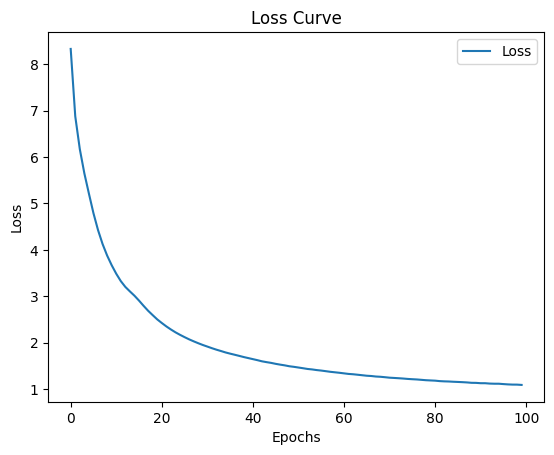

In [48]:
plt.plot(range(EPOCHS), loss_values, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')

# Adding a legend
plt.legend()

# Display the plot
plt.show()


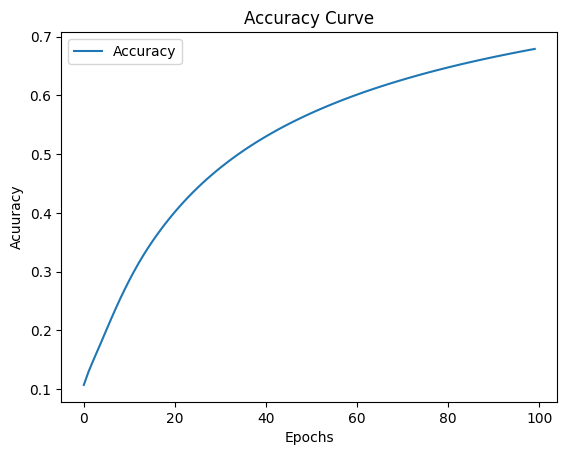

In [49]:
plt.plot(range(EPOCHS), accuracy_values, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acuuracy')
plt.title('Accuracy Curve')

# Adding a legend
plt.legend()

# Display the plot
plt.show()


In [ ]:
anvil.server.wait_forever()